 - Apprendre à manipuler le format des données (.txt et .ann)
 - Analyser la distribution des étiquettes NER présentes dans les données (fichier .ann)
- Calculer des statistiques descriptives, telles que le nombre moyen de tokens par texte et phrase.
- Visualiser la distribution des longueurs des phrases et textes avec un histogramme.

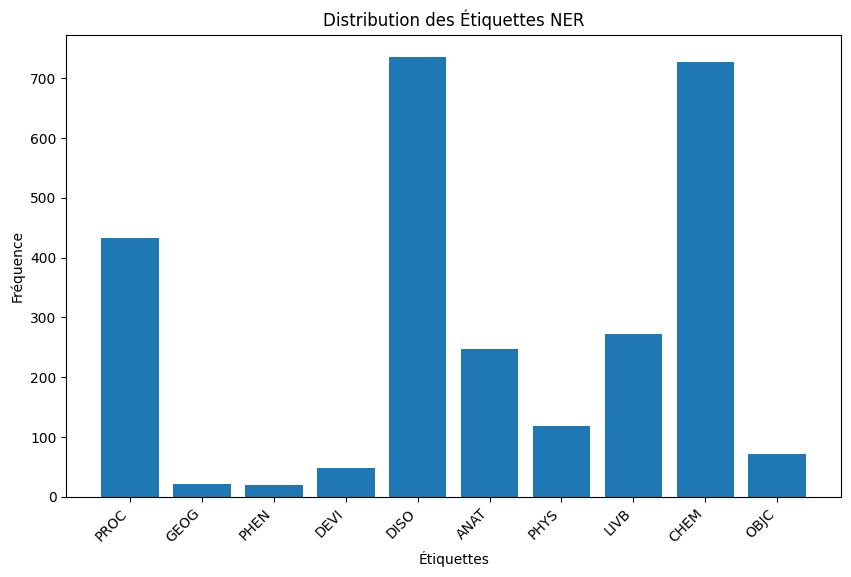

In [5]:
import os
from collections import Counter
import matplotlib.pyplot as plt

# ire et extraire étiquettes  .ann
def extract_labels_from_ann(file_path):
    labels = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.split("\t")
            if len(parts) > 1:
                label = parts[1].split(" ")[0]  
                labels.append(label)
    return labels

# analyser tous  fichiers .ann 
def analyze_directory(path):
    all_labels = []
    for root, dirs, files in os.walk(path):
        for filename in files:
            if filename.endswith(".ann"):  # filtrer  fichiers .ann
                file_path = os.path.join(root, filename)
                labels = extract_labels_from_ann(file_path)
                all_labels.extend(labels)  
    
    return all_labels

# afficher distribution étiquettes
def plot_label_distribution(labels):
    label_counts = Counter(labels)
    plt.figure(figsize=(10, 6))
    plt.bar(label_counts.keys(), label_counts.values())
    plt.xlabel('Étiquettes')
    plt.ylabel('Fréquence')
    plt.title('Distribution des Étiquettes NER')
    plt.xticks(rotation=45, ha="right")
    plt.show()

path = "./Data/EMEA/train"  
all_labels = analyze_directory(path)
plot_label_distribution(all_labels)


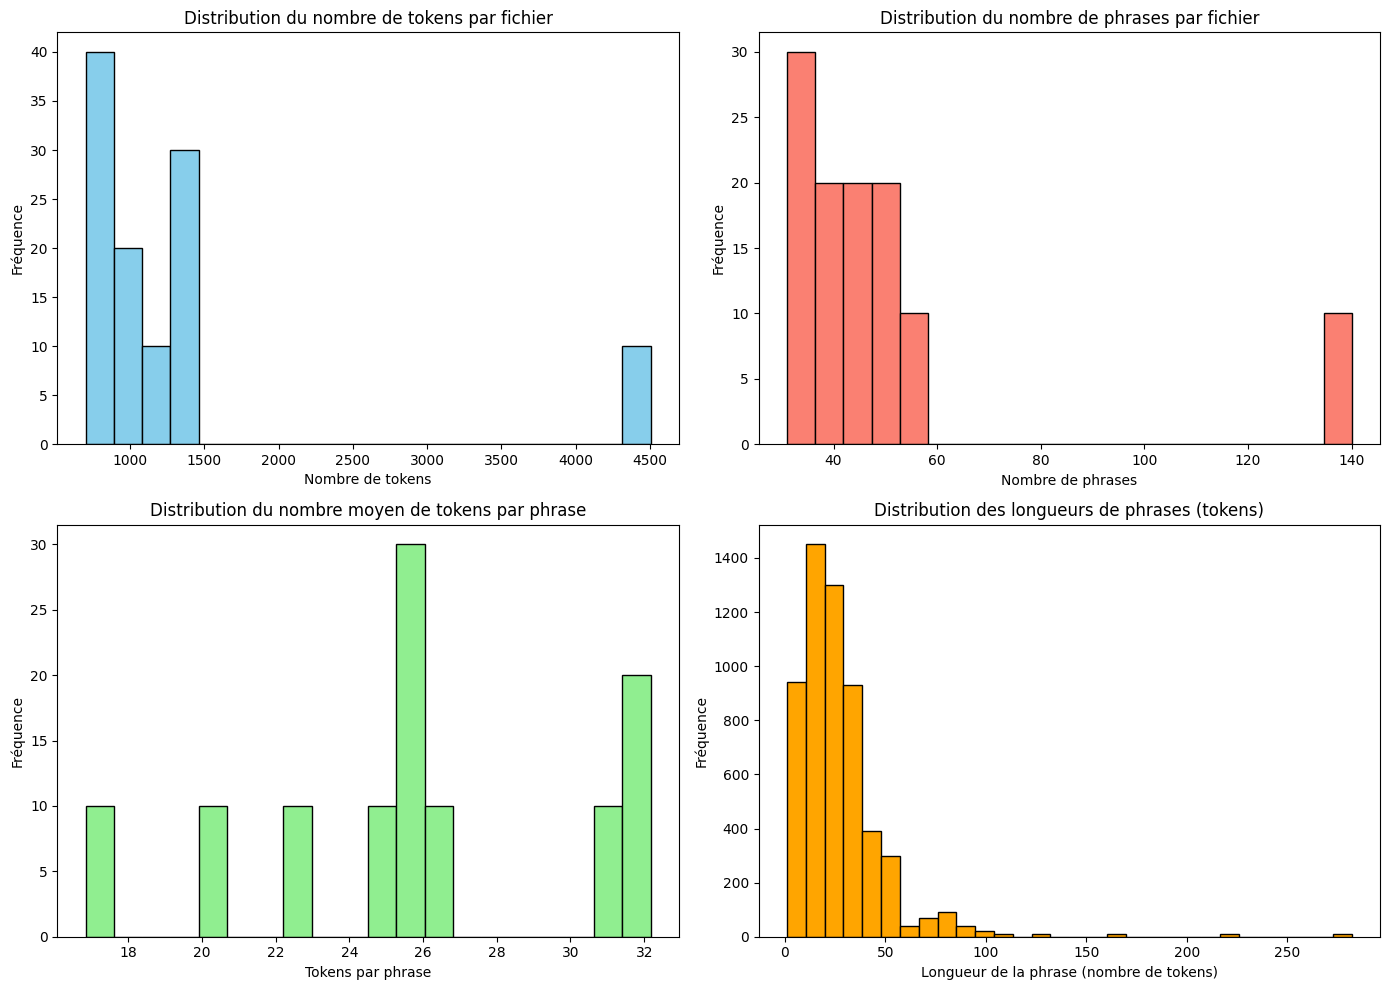

In [10]:
import os
import nltk
import matplotlib.pyplot as plt


def tokenize_text(text):
    if not text.strip():
        return []
    return nltk.word_tokenize(text)


def analyze_txt_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
    

    tokens = tokenize_text(text)

    sentences = nltk.sent_tokenize(text)
    
    if not sentences:
        return 0, 0, 0, []  

   
    num_tokens = len(tokens)
    
   
    sentence_lengths = [len(tokenize_text(sentence)) for sentence in sentences if tokenize_text(sentence)]  # Filtrer les phrases vides
    
    num_sentences = len(sentence_lengths) 
    
  
    avg_tokens_per_sentence = num_tokens / num_sentences if num_sentences > 0 else 0
    
    return num_tokens, num_sentences, avg_tokens_per_sentence, sentence_lengths


def analyze_directory_txt(directory_path):
    all_num_tokens = []  
    all_num_sentences = []  
    all_avg_tokens_per_sentence = []  
    all_sentence_lengths = []  
    
    for root, dirs, files in os.walk(directory_path):
        for filename in files:
            if filename.endswith(".txt"):  
                file_path = os.path.join(root, filename)
                num_tokens, num_sentences, avg_tokens_per_sentence, sentence_lengths = analyze_txt_file(file_path)
                all_num_tokens.append(num_tokens)
                all_num_sentences.append(num_sentences)
                all_avg_tokens_per_sentence.append(avg_tokens_per_sentence)
                all_sentence_lengths.extend(sentence_lengths)  
    
    return all_num_tokens, all_num_sentences, all_avg_tokens_per_sentence, all_sentence_lengths


def plot_statistics(all_num_tokens, all_num_sentences, all_avg_tokens_per_sentence, all_sentence_lengths):
    plt.figure(figsize=(14, 10))
    
    if all_num_tokens:
        plt.subplot(2, 2, 1)
        plt.hist(all_num_tokens, bins=20, color='skyblue', edgecolor='black')
        plt.title('Distribution du nombre de tokens par fichier')
        plt.xlabel('Nombre de tokens')
        plt.ylabel('Fréquence')
    
    if all_num_sentences:
        plt.subplot(2, 2, 2)
        plt.hist(all_num_sentences, bins=20, color='salmon', edgecolor='black')
        plt.title('Distribution du nombre de phrases par fichier')
        plt.xlabel('Nombre de phrases')
        plt.ylabel('Fréquence')
    
    if all_avg_tokens_per_sentence:
        plt.subplot(2, 2, 3)
        plt.hist(all_avg_tokens_per_sentence, bins=20, color='lightgreen', edgecolor='black')
        plt.title('Distribution du nombre moyen de tokens par phrase')
        plt.xlabel('Tokens par phrase')
        plt.ylabel('Fréquence')
    
    if all_sentence_lengths:
        plt.subplot(2, 2, 4)
        plt.hist(all_sentence_lengths, bins=30, color='orange', edgecolor='black')
        plt.title('Distribution des longueurs de phrases (tokens)')
        plt.xlabel('Longueur de la phrase (nombre de tokens)')
        plt.ylabel('Fréquence')
    
    plt.tight_layout()
    plt.show()


directory_path = "./Data/EMEA/train"  
all_num_tokens, all_num_sentences, all_avg_tokens_per_sentence, all_sentence_lengths = analyze_directory_txt(directory_path)
plot_statistics(all_num_tokens, all_num_sentences, all_avg_tokens_per_sentence, all_sentence_lengths)


In [21]:
import os
import nltk
from collections import Counter


def read_ann_file(ann_path):
    annotations = []
    with open(ann_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()  # Enlever les espaces au début et à la fin de la ligne
            if not line:  # Ignorer les lignes vides
                continue
            # Remplacer plusieurs espaces par une seule tabulation pour assurer une séparation correcte
            line = ' '.join(line.split())
            parts = line.split("\t")  # Séparer la ligne en colonnes à l'aide de tabulation
            if len(parts) >= 3:
                try:
                    start = int(parts[2])  # Position du début de l'annotation
                    end = int(parts[3])  # Position de la fin de l'annotation
                    label = parts[1]  # L'étiquette de l'annotation
                    annotations.append((start, end, label))  # Ajouter l'annotation à la liste
                except ValueError:
                    # Si la conversion échoue, imprimer l'erreur et passer à la ligne suivante
                    print(f"Erreur de format dans l'annotation: {line}")
                    continue
    return annotations







# Fonction pour associer les tokens avec leurs étiquettes
def associate_tokens_with_labels(txt_path, ann_path):
    with open(txt_path, 'r', encoding='utf-8') as f:
        text = f.read()

    # Tokenisation du texte en utilisant nltk
    tokens = nltk.word_tokenize(text)

    # Lire les annotations depuis le fichier .ANN
    annotations = read_ann_file(ann_path)

    # Liste des tokens et étiquettes associées
    token_labels = []
    
    # On va calculer la position de chaque token dans le texte original
    current_position = 0  # Position actuelle dans le texte
    token_positions = []  # Liste des positions des tokens

    for token in tokens:
        start_pos = text.find(token, current_position)  # Trouver la position du token
        end_pos = start_pos + len(token)  # La fin du token est à sa position + longueur du token
        token_positions.append((start_pos, end_pos))
        current_position = end_pos  # Mettre à jour la position actuelle pour éviter de trouver le même token plusieurs fois

    # Pour chaque annotation, on associe les tokens qui se trouvent dans l'intervalle [start, end]
    for start, end, label in annotations:
        for i, (token_start, token_end) in enumerate(token_positions):
            # Si le token est dans l'intervalle de l'annotation, on l'associe à l'étiquette
            if start >= token_start and end <= token_end:
                token_labels.append((tokens[i], label))
    
    return token_labels, tokens




# Fonction pour diviser le texte en phrases et associer les étiquettes
def divide_into_sentences_with_labels(txt_path, ann_path):
    # Récupérer les tokens et leurs étiquettes
    token_labels, tokens = associate_tokens_with_labels(txt_path, ann_path)

    # Découper le texte en phrases
    sentences = nltk.sent_tokenize(' '.join(tokens))
    
    # Diviser les étiquettes en phrases correspondantes
    sentence_labels = []
    start_idx = 0
    for sentence in sentences:
        sentence_tokens = nltk.word_tokenize(sentence)
        sentence_labels.append([])
        
        for token in sentence_tokens:
            for i, (tok, label) in enumerate(token_labels[start_idx:], start_idx):
                if token == tok:
                    sentence_labels[-1].append((token, label))
                    start_idx = i + 1
                    break
                
    return sentences, sentence_labels

# Fonction pour vérifier l'équilibre des étiquettes
def check_label_balance(ann_path):
    annotations = read_ann_file(ann_path)
    labels = [label for _, _, label in annotations]
    
    label_counter = Counter(labels)  # Compter la fréquence de chaque étiquette
    return label_counter

# Fonction pour analyser tous les fichiers .TXT et .ANN dans un dossier et ses sous-dossiers
def analyze_directory_txt_ann(directory_path):
    all_sentences = []
    all_sentence_labels = []
    all_label_counts = Counter()  # Compteur pour l'équilibre des étiquettes

    # Parcours récursif de tous les fichiers du répertoire et des sous-dossiers
    for root, dirs, files in os.walk(directory_path):
        for filename in files:
            if filename.endswith(".txt"):
                # Vérifier qu'il existe un fichier .ANN avec le même nom
                ann_filename = filename.replace('.txt', '.ann')
                ann_path = os.path.join(root, ann_filename)
                
                if os.path.exists(ann_path):  # Si le fichier .ANN existe
                    txt_path = os.path.join(root, filename)
                    
                    # Diviser le fichier en phrases et obtenir les étiquettes
                    sentences, sentence_labels = divide_into_sentences_with_labels(txt_path, ann_path)
                    all_sentences.extend(sentences)
                    all_sentence_labels.extend(sentence_labels)
                    
                    # Vérifier l'équilibre des étiquettes
                    label_balance = check_label_balance(ann_path)
                    all_label_counts.update(label_balance)  # Mettre à jour le compteur global des étiquettes

    return all_sentences, all_sentence_labels, all_label_counts

# Fonction pour afficher les résultats de l'équilibre des étiquettes
def print_label_balance(all_label_counts):
    print("Équilibre des étiquettes :")
    for label, count in all_label_counts.items():
        print(f"{label}: {count}")

# Exemple d'utilisation
directory_path = "./Data/EMEA/train"  # Remplacer par le chemin réel du dossier contenant les sous-dossiers

# Analyser tous les fichiers .TXT et .ANN dans le dossier
all_sentences, all_sentence_labels, all_label_counts = analyze_directory_txt_ann(directory_path)

# Afficher l'équilibre des étiquettes
print_label_balance(all_label_counts)

# Affichage des phrases et des étiquettes associées pour débogage (optionnel)
for sentence, labels in zip(all_sentences, all_sentence_labels):
    print(f"Phrases : {sentence}")
    print(f"Étiquettes : {labels}")



Équilibre des étiquettes :
Phrases : EMEA / H / C / 122 Recommandations standard Comme la lépirudine est excrétée et métabolisée en quasi-totalité par le rein ( voir également la rubrique 5 .
Étiquettes : []
Phrases : 2 ) , il est nécessaire de connaître l Les recommandations posologiques suivantes sont basées sur les résultats d Dans tous les autres cas , les ajustements posologiques seront basés sur la créatininémie .
Étiquettes : []
Phrases : La vitesse de perfusion doit être réduite selon les indications données dans le tableau 1 .
Étiquettes : []
Phrases : Une surveillance plus fréquente du TCA est obligatoire .
Étiquettes : []
Phrases : Reconstituer la solution comme il est indiqué en rubrique 6 .
Étiquettes : []
Phrases : 6 .
Étiquettes : []
Phrases : Bolus intraveineux initial : Le bolus intraveineux est préparé avec une solution dosée à 5 mg / ml .
Étiquettes : []
Phrases : pour une posologie de 0 , 2 mg / kg de poids corporel 4 La perfusion intraveineuse est préparée avec une

NameError: name 'annotations' is not defined

In [3]:
import os
import spacy
import random
from spacy.training.example import Example

# Fonction pour charger les données à partir des fichiers .TXT et .ANN
def load_data_from_files(txt_file, ann_file):
    annotations = []
    
    # Charger le texte
    with open(txt_file, 'r', encoding='utf-8') as f:
        text = f.read()

    # Charger les annotations
    with open(ann_file, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split("\t")
            
            # Vérifier si la ligne contient 5 éléments
            if len(parts) == 5:
                entity_id, label, start, end, entity_text = parts
                start, end = int(start), int(end)
                annotations.append((start, end, entity_text))
            else:
                # Si la ligne est mal formatée, la signaler ou l'ignorer
                print(f"Ligne mal formatée dans {ann_file}: {line.strip()}")
    
    return text, annotations


# Fonction pour préparer les données d'entraînement à partir des fichiers dans le dossier et ses sous-dossiers
def prepare_training_data(data_folder):
    """Prépare les données d'entraînement à partir de fichiers .ANN et .TXT dans le dossier et sous-dossiers."""
    training_data = []
    
    # Parcours tous les fichiers du dossier et sous-dossiers
    for root, dirs, files in os.walk(data_folder):
        for file in files:
            if file.endswith(".txt"):
                txt_file = os.path.join(root, file)
                ann_file = os.path.join(root, file.replace(".txt", ".ann"))
                
                if os.path.exists(ann_file):
                    text, annotations = load_data_from_files(txt_file, ann_file)
                    entities = [(start, end, label) for start, end, label in annotations]
                    training_data.append((text, {'entities': entities}))
    
    return training_data

# Fonction pour entraîner le modèle de reconnaissance d'entités nommées (NER)
def train_ner_model(training_data, model=None, n_iter=10):
    """Entraîne un modèle NER avec spaCy à partir des données d'entraînement."""
    if model is None:
        # Si aucun modèle préexistant, charger le modèle français de base
        nlp = spacy.blank("fr")
    else:
        # Charger le modèle existant
        nlp = spacy.load(model)

    # Ajouter un pipeline de reconnaissance d'entités (NER)
    if "ner" not in nlp.pipe_names:
        ner = nlp.create_pipe("ner")
        nlp.add_pipe("ner", last=True)
    else:
        ner = nlp.get_pipe("ner")

    # Ajouter les nouvelles entités dans le NER
    for _, annotations in training_data:
        for ent in annotations["entities"]:
            ner.add_label(ent[2])

    # Entraîner le modèle
    optimizer = nlp.begin_training()
    for itn in range(n_iter):
        print(f"Training iteration {itn + 1}")
        random.shuffle(training_data)
        for text, annotations in training_data:
            # Créer un objet Example
            example = Example.from_dict(nlp.make_doc(text), annotations)
            nlp.update([example], drop=0.5, losses={})

    return nlp

# Fonction principale pour entraîner le modèle
def main(data_folder, output_model_path, n_iter=10):
    # Préparer les données d'entraînement
    training_data = prepare_training_data(data_folder)
    
    # Entraîner le modèle NER
    ner_model = train_ner_model(training_data, n_iter=n_iter)
    
    # Sauvegarder le modèle entraîné
    ner_model.to_disk(output_model_path)
    print(f"Modèle entraîné et sauvegardé dans {output_model_path}")

# Exemple d'utilisation
data_folder = './Data/EMEA/train'  # Remplace ce chemin par le chemin de ton dossier de données
output_model_path = '/path/to/save/ner_model'  # Remplace ce chemin par le chemin où tu souhaites sauvegarder le modèle

# Entraîner le modèle sur 10 itérations
main(data_folder, output_model_path, n_iter=10)


Ligne mal formatée dans ./Data/EMEA/train/PROC/345_2.ann: T5	PROC 353 366	créatininémie
Ligne mal formatée dans ./Data/EMEA/train/PROC/345_2.ann: T6	PROC 385 394	perfusion
Ligne mal formatée dans ./Data/EMEA/train/PROC/345_2.ann: T8	PROC 592 610	Bolus intraveineux
Ligne mal formatée dans ./Data/EMEA/train/PROC/345_2.ann: T9	PROC 626 644	bolus intraveineux
Ligne mal formatée dans ./Data/EMEA/train/PROC/345_2.ann: T13	PROC 758 781	perfusion intraveineuse
Ligne mal formatée dans ./Data/EMEA/train/PROC/345_2.ann: T17	PROC 943 952	perfusion
Ligne mal formatée dans ./Data/EMEA/train/PROC/345_2.ann: T21	PROC 1171 1184	thérapeutique
Ligne mal formatée dans ./Data/EMEA/train/PROC/345_2.ann: T24	PROC 1297 1304	traités
Ligne mal formatée dans ./Data/EMEA/train/PROC/345_2.ann: T30	PROC 1478 1488	traitement
Ligne mal formatée dans ./Data/EMEA/train/PROC/345_2.ann: T53	PROC 1985 1995	traitement
Ligne mal formatée dans ./Data/EMEA/train/PROC/345_2.ann: T67	PROC 1952 1955	TCA
Ligne mal formatée dans .

KeyboardInterrupt: 